### 5.2.2 Gathering some data
We'll start by making a note of temperature data in good old Celsius and measurements from our new thermomter, and figure things out.

In [1]:
import torch

t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

Here, the t_c values are temperatures in Celsisu, and the t_u values are our unknown units. We can expect noise in both measurements, coming from the devices themselves and from our approximate readings.

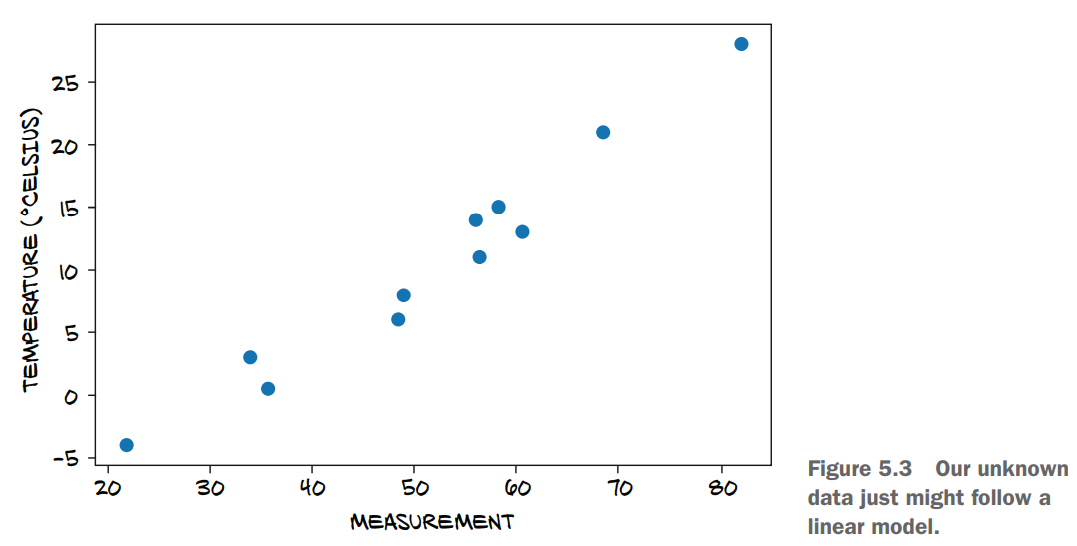

In [2]:
from IPython.display import Image
Image("p108.png", height=500, width=500)

### 5.3.1 From problem back to PyTorch
We've already created on our data tensors, so now let's write out the model as a Python function:

In [3]:
def model(t_u, w, b):
    return w*t_u + b

Define our loss:

In [4]:
def loss_fn(t_p, t_c):
    square_diffs = (t_p - t_c)**2
    return square_diffs.mean()

Initialize the parameters, invoke the model

In [5]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [6]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

Decreasing the loss

In [7]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

We typically should scale the rate of change by a small factor. This scaling factor has many names; the one we use in machine learning is $learning\_rate$

In [8]:
learning_rate = 1e-2
w = w - learning_rate*loss_rate_of_change_w

Do the same with b

In [9]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate*loss_rate_of_change_b

By reiterating these evaluations, we will converge to an optimal value of the parameters for which the loss computed on  the given data is minimal.

Computing the derivatives

In [10]:
def dloss_fn(t_p, t_c):
    dsq_diffs=2* (t_p - t_c) / t_p.size(0)
    return dsq_diffs

Applying the derivatives to the model

In [11]:
def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

Defining the gradient function

In [12]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

### 5.4.3 Iterating to fit the model
There are several stopping criteria; for now, we'll stick to a fixed number of iterations.

__training loop__: We call a training iteration during which we update the parameters for all of our training samples an *epoch*.

In [13]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

Let's now invoke our training loop:

In [14]:
training_loop(n_epochs = 100,
              learning_rate = 1e-2,
              params = torch.tensor([1.0, 0.0]),
              t_u = t_u,
              t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
    Params: tensor([2568.4011,   45.1637])
    Grad:   tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
    Params: tensor([-148527.7344,   -2616.3931])
    Grad:   tensor([15109614.0000,   266155.6875])
...
Epoch 10, Loss 90901105189019073810297959556841472.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

The optimization process is unstable: it *diverges* instead of converging to a minimum. We want to see smaller and smaller updates to $params$, not large.

In [15]:
training_loop(n_epochs = 100,
              learning_rate = 1e-4,
              params = torch.tensor([1.0, 0.0]),
              t_u = t_u,
              t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

There's another troublemaker in the update term: the gradient itself. Let's go back and look at $grad$ at epoch 1 during optimization.

### 5.4.4 Normalizing inputs
We can see that the first-epoch gradient for the weight is about 50 times larger than the gradient for the bias. This means the weight and bias live in differently scaled spaces.

There's a simpler way to keep things in check: changing the inputs so that the gradients aren't quite so different. We can make sure the range of the input doesn’t get too far from the range of –1.0 to 1.0, roughly speaking.

In [16]:
t_un = 0.1*t_u

training_loop(n_epochs = 100,
              learning_rate = 1e-2,
              params = torch.tensor([1.0, 0.0]),
              t_u = t_un,
              t_c = t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

Even though we set our learning rate back to 1e-2, parameters don’t blow up during iterative updates.

Let’s run the loop for enough iterations to see the changes in params get small. We’ll change n_epochs to 5,000:

In [17]:
params = training_loop(n_epochs = 5000,
                       learning_rate = 1e-2,
                       params = torch.tensor([1.0, 0.0]),
                       t_u = t_un,
                       t_c = t_c,
                       print_params = False)
params

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


tensor([  5.3671, -17.3012])

### 5.4.5 Visualizing
plotting our data

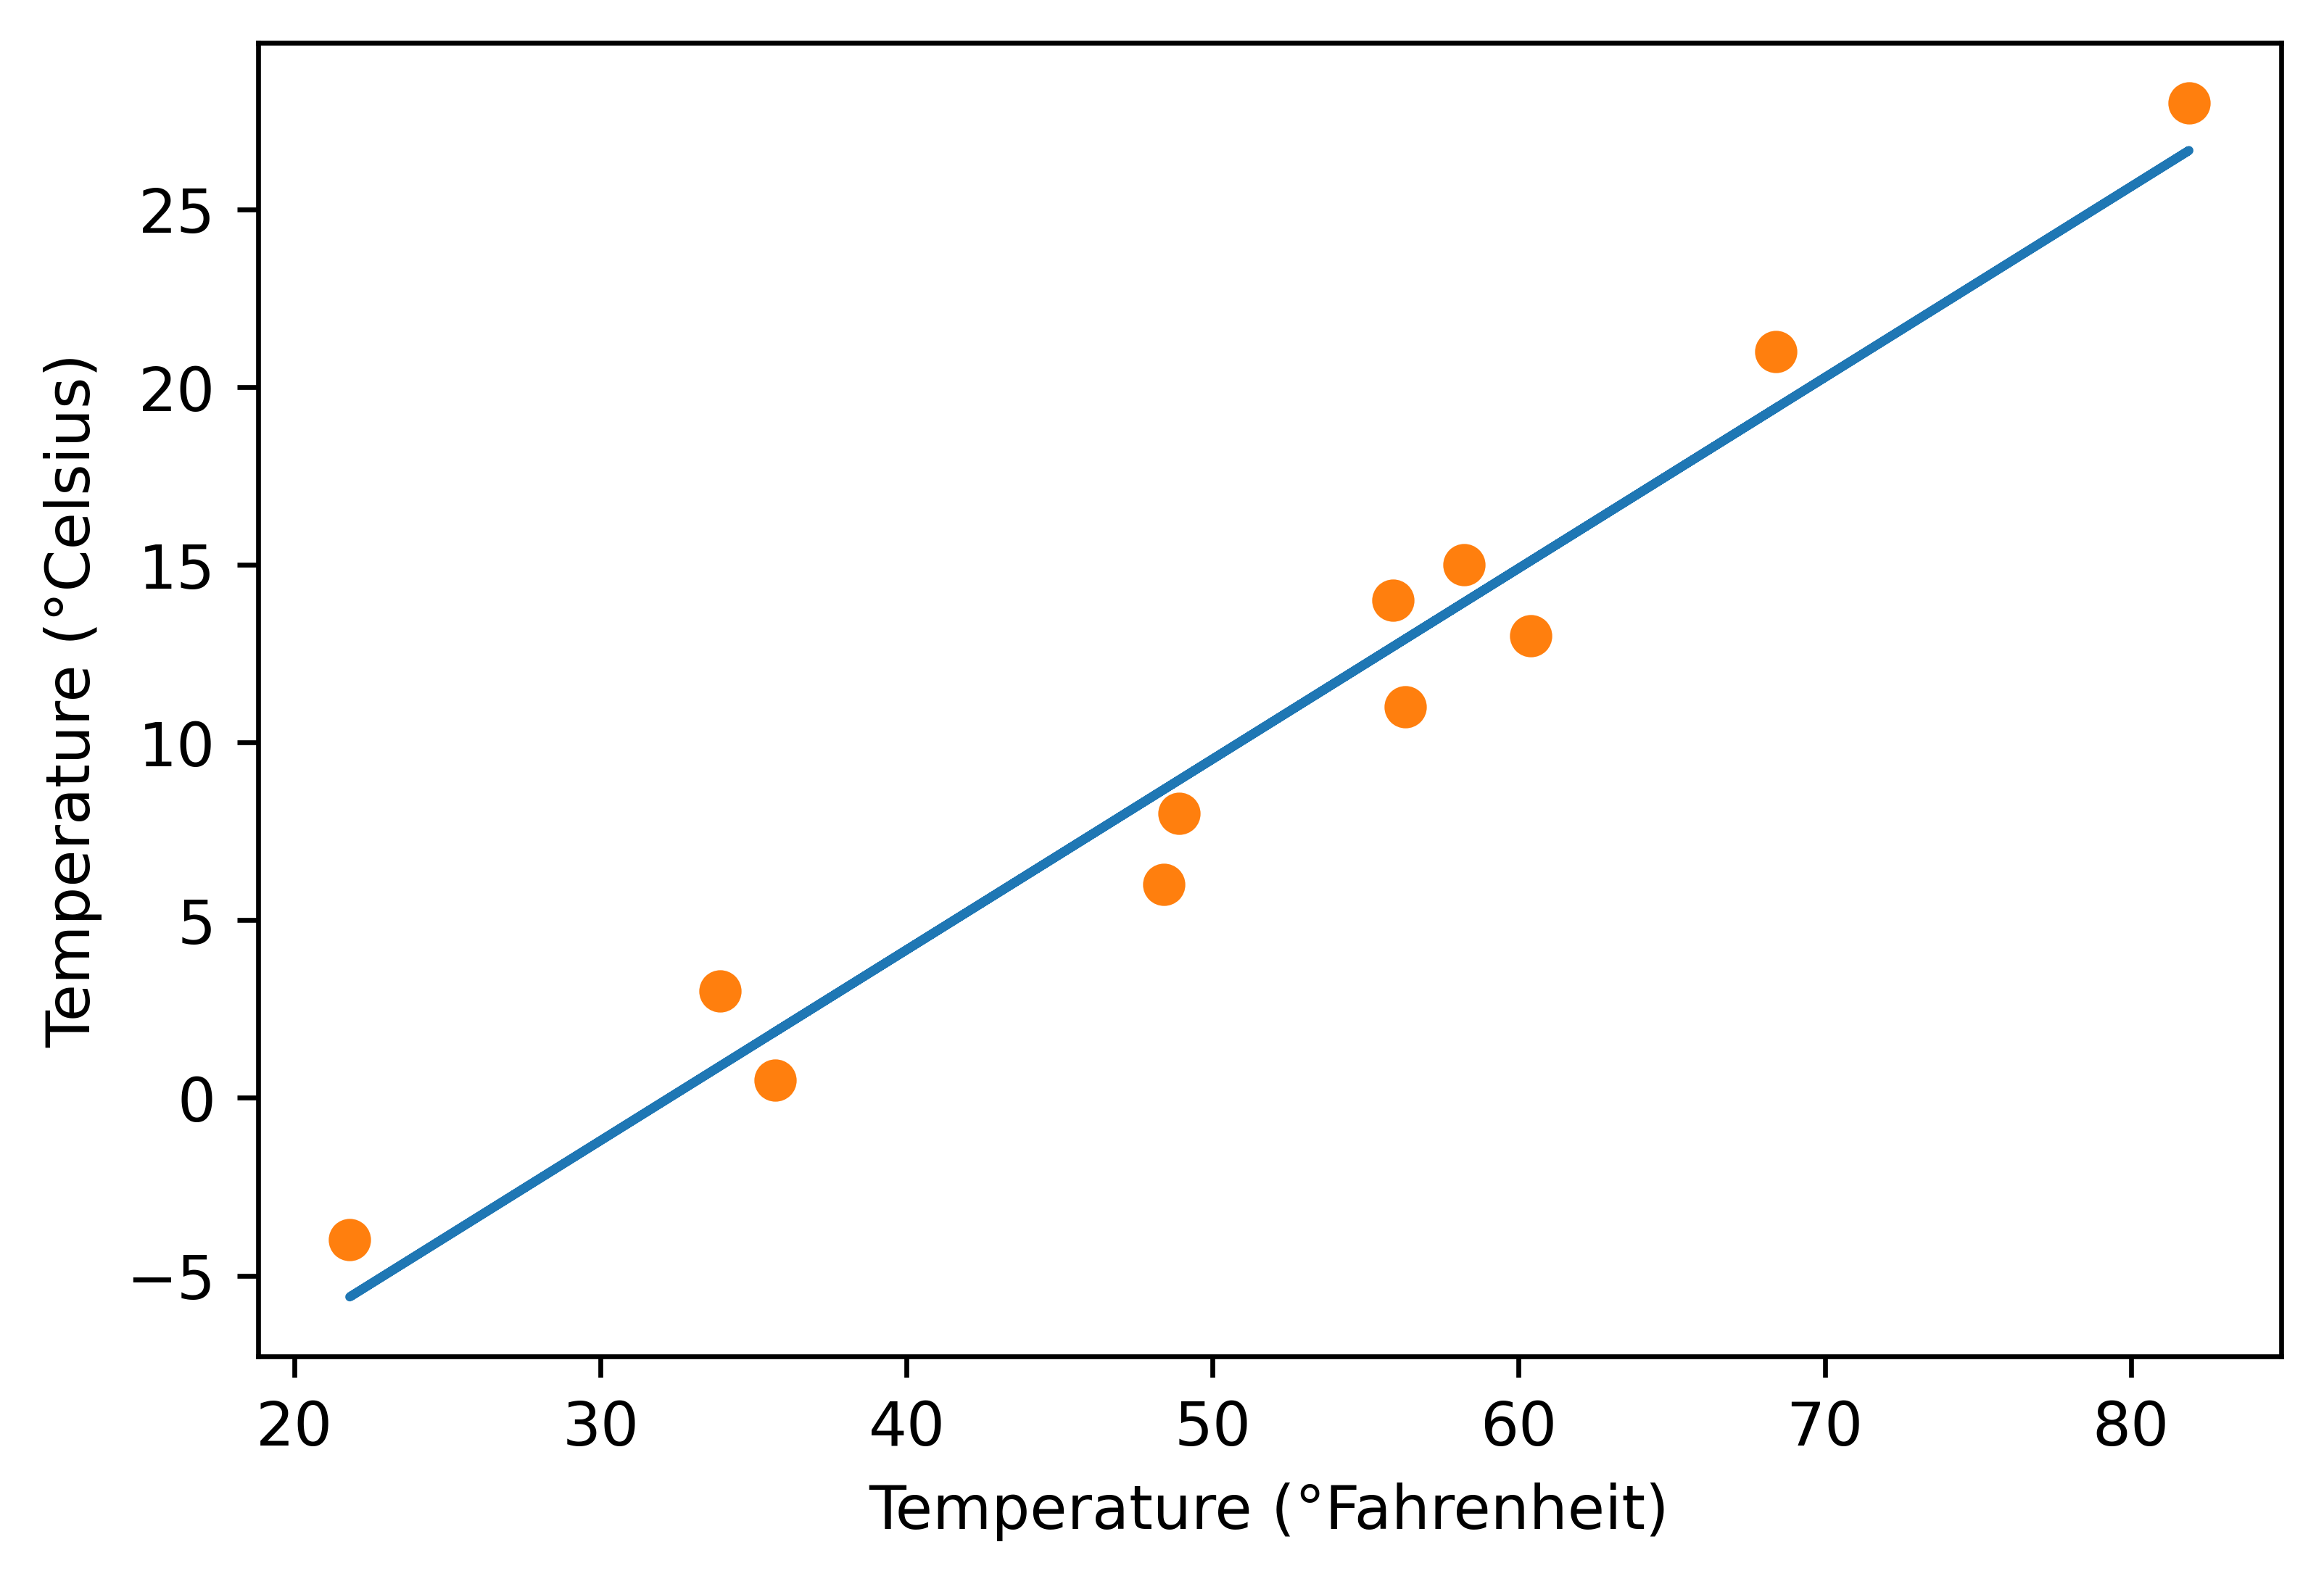

In [18]:
from matplotlib import pyplot as plt

t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

We're using a Python trick called *argument unpacking*. Here, $*params$ means to pass the elements of $params$ as individual arguments. So here, model(t\_un, \*params) is equivalent to model(t\_un, params[0], params[1])

### 5.5.1 Computing the gradient automatically
Applying autograd. At this point, the best way to proceed is to rewrite thermomter calibration code, this time using autograd.

In [19]:
def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

params = torch.tensor([1.0, 0.0], requires_grad=True)

Notice the argument $requires\_grad=True$ is telling PyTorch to track the entire family tree of tensors resulting from operations on $params$. In case these functions are differentiable, the value of the derivative will be automatically populated as a $grad$ attribute of the $params$ tensor.

In general, all PyTorch tensors have an attribute named $grad$. Normally, it's None:

In [20]:
params.grad is None

True

Call the model and compute the loss, and then call $backward$ on the $loss$ tensor:

In [21]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

At this point, the $grad$ attribute of $params$ contains the derivatives of the loss with respect to each element of params.

In order to prevent incorrect value for the gradient from occuring, we need to *zero the gradient explicitly* at each iteration. We can do this easily using the in-place *zero_* method:

In [22]:
if params.grad is not None:
    params.grad.zero_()

Having this remainder drilled into our heads, let's see what our autograd-enabled training code looks like, starts to finish:

In [23]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():
            params -= learning_rate * params.grad
            
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    
    return params

Let's see if it works:

In [24]:
training_loop(n_epochs=5000,
              learning_rate=1e-2,
              params = torch.tensor([1.0, 0.0], requires_grad=True),
              t_u=t_un,
              t_c=t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

The result is the same as we got previously. It means that while we are *capable* of computing derivatives by hand, we no longer need to.

In [25]:
import torch.optim as optim

dir(optim)[:6]

['ASGD', 'Adadelta', 'Adagrad', 'Adam', 'AdamW', 'Adamax']

Using a gradient descent optimizer: Let's create $params$ and instantiate a gradient descent optimizer:

In [26]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr = learning_rate)

Here SGD stands for *stochastic gradient descent*. The term *stochastic* comes from the fact that the gradient is typically obtained by averaging over a random subset of all inputs samples, called a *minibatch*. However, the optimizer does not know if the loss was evaluated on all the samples or a random subset of them, so the algorithms is literally the same in the two cases.

In [27]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

The value of *params* is updated upon calling *step* without us having to touch it ourselves!

Don't forget to zero grad

In [28]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr = learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

Let's update our training loop accordingly:

In [29]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [30]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(n_epochs = 5000,
              optimizer = optimizer,
              params = params, 
              t_u = t_un,
              t_c = t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

Again, we get the same result as before. Great: this is further confirmation that we know how to descend a gradient by hand.

### 5.5.3 Training, validation, and overfitting

In [33]:
n_samples = t_u.shape[0]
n_val = int(0.2*n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 8, 10,  7,  0,  1,  5,  9,  4,  2]), tensor([6, 3]))

We just got index tensors that we can use to build training and validation sets starting from the data tensors:

In [35]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

Our training loop doesn't really change, just additionally evaluate the validation loss at every epoch, to recognize if we're overfitting.

In [36]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        val_t_p = model(val_t_u, *params) 
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"f" Validation loss {val_loss.item():.4f}")
    return params

In [38]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr = learning_rate)

training_loop(n_epochs=3000,
              optimizer=optimizer,
              params=params,
              train_t_u = train_t_un,
              val_t_u = val_t_un, 
              train_t_c = train_t_c,
              val_t_c = val_t_c)

Epoch 1, Training loss 54.6022, Validation loss 196.2941
Epoch 2, Training loss 28.9488, Validation loss 113.8239
Epoch 3, Training loss 24.0091, Validation loss 86.6818
Epoch 500, Training loss 8.5065, Validation loss 23.6403
Epoch 1000, Training loss 4.3771, Validation loss 10.2660
Epoch 1500, Training loss 3.2013, Validation loss 6.3667
Epoch 2000, Training loss 2.8664, Validation loss 5.2080
Epoch 2500, Training loss 2.7710, Validation loss 4.8522
Epoch 3000, Training loss 2.7439, Validation loss 4.7371


tensor([  5.2457, -17.0469], requires_grad=True)